# Наивный Байесовский Классификатор для классификации спам-сообщений

In [1]:
import numpy as np
import pandas as pd

Прочитаем файл (разделителем здесь выступает символ табуляции).

In [2]:
sms_data = pd.read_csv('SMSSpamCollection', header=None, sep='\t', names=['Label', 'SMS'])
sms_data.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Посмотрим, сколько объектов каждого класса присутствует в датасете.

In [3]:
sms_data.groupby('Label').count()

,SMS
Label,
ham,4825
spam,747


### Предобработка данных

Удаляем символы, не являющиеся буквами, приводим тексты SMS к нижнему регистру, разбиваем строки на слова.

In [5]:
sms_data_clean = sms_data.copy()

In [6]:
sms_data_clean['SMS'] = sms_data_clean['SMS'].str.replace('\W+', ' ', regex=True)

sms_data_clean['SMS'] = sms_data_clean['SMS'].str.replace('\s+', ' ', regex=True).str.strip()
sms_data_clean['SMS'] = sms_data_clean['SMS'].str.lower()
sms_data_clean['SMS'] = sms_data_clean['SMS'].str.split()

sms_data_clean['SMS'].head()

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, don, t, think, he, goes, to, usf, he,...
Name: SMS, dtype: object

In [7]:
sms_data_clean['Label'].value_counts() / sms_data_clean.shape[0] * 100

ham     86.593683
spam    13.406317
Name: Label, dtype: float64

### Разделение на обучающую и тестовую выборки

In [8]:
train_data = sms_data_clean.sample(frac=0.8, random_state=42)
test_data = sms_data_clean.drop(train_data.index)

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [9]:
train_data['Label'].value_counts() / train_data.shape[0] * 100

ham     86.698071
spam    13.301929
Name: Label, dtype: float64

In [10]:
train_data.shape

(4458, 2)

In [11]:
test_data['Label'].value_counts() / test_data.shape[0] * 100

ham     86.175943
spam    13.824057
Name: Label, dtype: float64

In [12]:
test_data.shape

(1114, 2)

Мы видим, что и в обучающей, и в тестовой выборке содержится примерно 86-87% спама – как и в нашем оригинальном датасете.

### Список слов

Создаём список всех слов, встречающихся в обучающей выборке.

In [13]:
vocabulary = list(set(train_data['SMS'].sum()))

In [14]:
vocabulary[11:20]

['recreation',
 'wan2',
 'kickboxing',
 'establish',
 'tonexs',
 'aha',
 'lov',
 'lifetime',
 'jorge']

In [15]:
len(vocabulary)

7816

### Рассчитаем частоты слов

Для каждого SMS-сообщения посчитаем, сколько раз в нём встречается каждое слово.

In [16]:
word_counts_per_sms = pd.DataFrame([
    [row[1].count(word) for word in vocabulary]
    for _, row in train_data.iterrows()], columns=vocabulary)

word_counts_per_sms.head()

Добавим частоты каждого слова в обучающий датасет.

In [17]:
train_data = pd.concat([train_data, word_counts_per_sms], axis=1)

In [18]:
train_data.head()

,Label,SMS,ym,anand,percent,89034,one,ip,junna,bcm,...,542,onum,aberdeen,3d,stereo,anal,election,smiles,postcode,cooked
0,ham,"[squeeeeeze, this, is, christmas, hug, if, u, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[and, also, i, ve, sorta, blown, him, off, a, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[mmm, thats, better, now, i, got, a, roast, do...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,"[mm, have, some, kanji, dont, eat, anything, h...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[so, there, s, a, ring, that, comes, with, the...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Значения для формулы Байеса

Посчитаем необходимые значения для формулы Байеса.

In [19]:
alpha = 1

In [20]:
Nvoc = len(vocabulary)
Pspam = train_data['Label'].value_counts()['spam'] / train_data.shape[0]
Pham = train_data['Label'].value_counts()['ham'] / train_data.shape[0]
Nspam = train_data.loc[train_data['Label'] == 'spam', 'SMS'].apply(len).sum()
Nham = train_data.loc[train_data['Label'] == 'ham', 'SMS'].apply(len).sum()

In [22]:
def p_w_spam(word):
    if word in train_data.columns:
        return (train_data.loc[train_data['Label'] == 'spam', word].sum() + alpha) / (Nspam + alpha*Nvoc)
    else:
        return 1

def p_w_ham(word):
    if word in train_data.columns:
        return (train_data.loc[train_data['Label'] == 'ham', word].sum() + alpha) / (Nham + alpha*Nvoc)
    else:
        return 1

### Готовим алгоритм классификации

In [23]:
def classify(message):
    p_spam_given_message = Pspam
    p_ham_given_message = Pham
    for word in message:
        p_spam_given_message *= p_w_spam(word)
        p_ham_given_message *= p_w_ham(word)
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'классификация некорректна'

### Используем тестовые данные

In [24]:
test_data['predicted'] = test_data['SMS'].map(classify)

In [25]:
test_data.head()

,Label,SMS,predicted
0,ham,"[u, dun, say, so, early, hor, u, c, already, t...",ham
1,ham,"[nah, i, don, t, think, he, goes, to, usf, he,...",ham
2,spam,"[freemsg, hey, there, darling, it, s, been, 3,...",ham
3,spam,"[had, your, mobile, 11, months, or, more, u, r...",spam
4,ham,"[oh, k, i, m, watching, here]",ham


In [27]:
correct = (test_data['predicted'] == test_data['Label']).sum() / test_data.shape[0]
print(f"Правильных предсказаний {correct * 100:3f} %")

Правильных предсказаний 98.025135 %


In [29]:
test_data.loc[test_data['predicted'] != test_data['Label']].head()

,Label,SMS,predicted
2,spam,"[freemsg, hey, there, darling, it, s, been, 3,...",ham
96,ham,"[waiting, for, your, call]",spam
182,ham,"[26th, of, july]",spam
269,spam,"[sms, ac, jsco, energy, is, high, but, u, may,...",ham
344,ham,"[the, last, thing, i, ever, wanted, to, do, wa...",классификация некорректна


# Наивный байесовский классификатор в sklearn
Ура, мы реализовали наивный байесовский классификатор с нуля!
А теперь посмотрим, как то же самое можно сделать с помощью библиотеки scikit-learn.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

Прочитаем заново csv-файл и предобработаем данные. Разбивать сообщения на слова в этот раз не нужно, мы сделаем это далее с помощью встроенных инструментов

In [32]:
df = pd.read_csv(
    "SMSSpamCollection.csv", header=None, sep="\t", names=["Label", "SMS"]
)

df["SMS"] = df["SMS"].str.replace(r"\W+", " ", regex=True).str.lower()

df['SMS'] = df['SMS'].str.replace('\s+', ' ', regex=True).str.strip()
df['SMS'] = df['SMS'].str.lower()
df.head()

,Label,SMS
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor u c already then say
4,ham,nah i don t think he goes to usf he lives arou...


Преобразуем строки в векторный вид – то есть, снова создадим таблицу с частотами слов. Но в этот раз воспользуемся встроенным в sklearn классов CountVectorizer().

In [34]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["SMS"])
y = df["Label"]

print(X.shape, y.shape)

(5572, 8713) (5572,)


С помощью функции `train_test_split` из scikit-learn разобьём выборку на обучающую и тестовую в пропорции 80/20. Не забудем сделать стратификацию!

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [37]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")

Accuracy: 0.979372197309417


# РАВНОМЕРНОЕ РАСПРЕДЕЛЕНИЕ

In [1]:
import numpy as np
from scipy.stats import randint

In [3]:
# Задаём возможные значения случайной величины
x = np.arange(1, 7)
# Задаём интервал, на котором будут распределяться наши вероятности
disc_uni_dist = randint(1, 7)
# Вычисляем вероятности выпадения каждого значения случайной величины
pmf = disc_uni_dist.pmf(x)
pmf

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In [4]:
# Рассчитаем кумулятивную вероятность
cdf = disc_uni_dist.cdf(x)

print(cdf)

# [0.16666667 0.33333333 0.5 0.66666667 0.83333333 1]

[0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.        ]


Вы участвуете в розыгрыше бесплатного места на новый курс по Data Science. Вы знаете, что участников 250.

Какова вероятность, что на курс попадёт кто-то из первых пятидесяти зарегистрировавшихся?

In [5]:
# Задаём возможные значения случайной величины
x = np.arange(1, 251)
# Задаём интервал, на котором будут распределяться наши вероятности
disc_uni_dist = randint(1,251)
# Вычисляем вероятности выпадения каждого значения случайной величины
cdf = disc_uni_dist.cdf(x)
# Ищем вероятность того, что на курс попадёт кто-то из первых 50 зарегистрировавшихся
print(cdf[49])

0.2


# РАСПРЕДЕЛЕНИЕ БЕРНУЛЛИ

C:\Users\sveta\AppData\Local\Temp\ipykernel_3968\2561418568.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(data,


[Text(0.5, 0, 'Значение случайной величины'), Text(0, 0.5, 'Частота')]

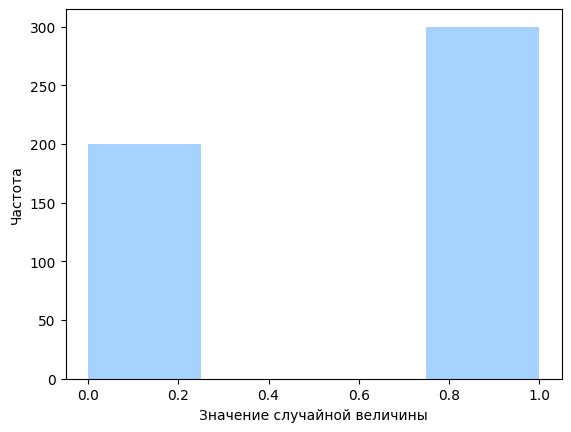

In [6]:
from scipy.stats import bernoulli
import seaborn as sns

data = bernoulli.rvs(size=500,p=0.6)
ax = sns.distplot(data,
                  kde = False,
                  color='dodgerblue')
ax.set(xlabel='Значение случайной величины', ylabel='Частота')

In [8]:
unique, counts = np.unique(data, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 200]
 [  1 300]]


# БИНОМИАЛЬНОЕ РАСПРЕДЕЛЕНИЕ

In [9]:
import scipy

scipy.stats.binom.pmf(8,10,0.8)+scipy.stats.binom.pmf(9,10,0.8)+scipy.stats.binom.pmf(10,10,0.8)

0.6777995264

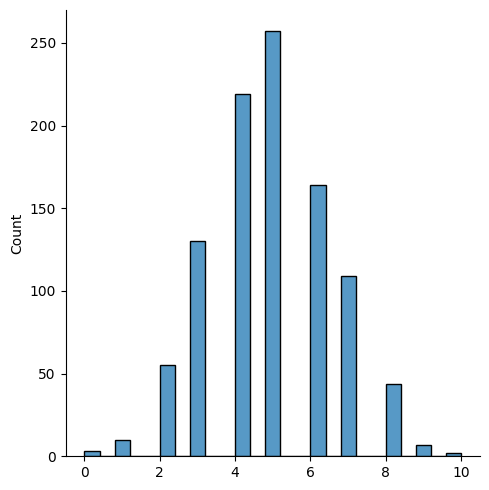

In [10]:
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns

x = random.binomial(n=10, p=0.5, size=10)

sns.displot(random.binomial(n=10, p=0.5, size=1000))

plt.show()

# РАСПРЕДЕЛЕНИЕ ПУАССОНА

In [11]:
import scipy

scipy.stats.distributions.poisson.pmf(5, 4.5)

0.17082685848611215

C:\Users\sveta\AppData\Local\Temp\ipykernel_3968\2227624355.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(random.poisson(lam=3, size=1000), kde=False)


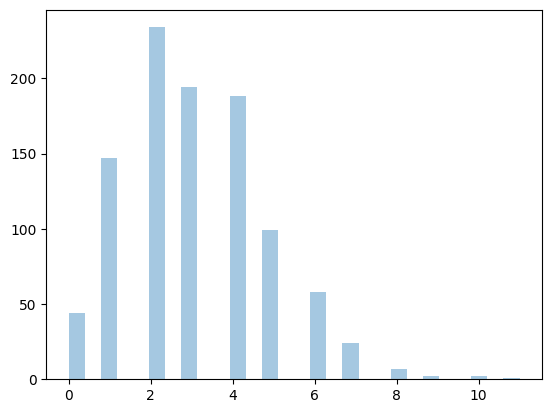

In [12]:
from numpy import random

sns.distplot(random.poisson(lam=3, size=1000), kde=False)

plt.show()

In [13]:
from numpy import random

scipy.stats.distributions.poisson.pmf(16, 16)

0.09921753162215541

# НЕПРРЕРЫВНОЕ РАВНОМЕРНОЕ РАСПРДЕЛЕНИЕ

In [14]:
data = uniform.rvs(size=10000, loc = 10, scale=30)
ax = sns.distplot(data,
                  bins=50)
ax.set(xlabel='Равномерное распределение', ylabel='Плотность')

NameError: name 'uniform' is not defined

# НЕПРЕРЫВНОЕ НОРМАЛЬНОЕ РАСПРЕДЕЛЕНИЕ

In [15]:
data = norm.rvs(size=10000,loc=4,scale=5)
 
ax = sns.distplot(data,
                  bins=50)
ax.set(xlabel='Нормальное распределение', ylabel='Плотность')


NameError: name 'norm' is not defined

In [16]:
# стандартизация данных

from numpy import asarray
from sklearn.preprocessing import StandardScaler
data = asarray([[93, 44],
                [4, 2],
                [36, 1],
                [14, 29],
                [78, 21]])
print(data)
scaler = StandardScaler()
scaled = scaler.fit_transform(data)
print(scaled)

[[93 44]
 [ 4  2]
 [36  1]
 [14 29]
 [78 21]]
[[ 1.37243726  1.50201177]
 [-1.17229016 -1.06239857]
 [-0.25733199 -1.12345596]
 [-0.88636573  0.58615094]
 [ 0.94355062  0.09769182]]


# НЕПРЕРЫВНОЕ ЭКСПОНЕНЦИАЛЬНОЕ РАСПРЕДЕЛЕНИЕ

In [17]:
data = expon.rvs(scale=1,loc=0,size=1000)
ax = sns.distplot(data,
                  bins=50)
ax.set(xlabel='Экспоненциальное распределение', ylabel='Плотность')

NameError: name 'expon' is not defined